# Proyecto: Estimación de Niveles de Obesidad

**Notebook 2: Modelo de predicción de obesidad**

A continuación se creará un modelo para predecir el tipo de obesidad que el individuo pueda tener. El número de columnas que existen en el dataset son 17, de las cuales una será el objeto a predecir.

La columna a predecir es **NObeyesdad**, la cual tiene 7 valores distintos. Estas cadenas serán convertidas a valores numéricos para poder ser ingresados en el algoritmo.

- **NObeyesdad**:

	- Insufficient_Weight
	- Normal_Weight
	- Overweight_Level_I
	- Overweight_Level_II
	- Obesity_Type_I
	- Obesity_Type_II
	- Obesity_Type_III

Todas las demás columnas (16) se usarán para entrenar el algoritmo.

## Importar librerías

In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import os
from pathlib import Path


In [3]:
#Rutas
#Rutas
os.makedirs('data/raw', exist_ok=True)
os.makedirs('data/processed', exist_ok=True)

IN_DIR = Path("data/raw")
OUT_DIR = Path("data/processed")

#Ruta del CSV crudo
RAW_PATH = IN_DIR / "obesity_estimation_modified.csv"
ORIGINAL_PATH = IN_DIR / "obesity_estimation_original.csv"



CLEAN_PATH = OUT_DIR / "obesity_clean.csv"

## EDA

In [5]:
obesity_data = pd.read_csv(ORIGINAL_PATH)
obesity_data

,Gender,Age,Height,Weight,family_history_with_overweight,FAVC,FCVC,NCP,CAEC,SMOKE,CH2O,SCC,FAF,TUE,CALC,MTRANS,NObeyesdad
0,Female,21.000000,1.620000,64.000000,yes,no,2.0,3.0,Sometimes,no,2.000000,no,0.000000,1.000000,no,Public_Transportation,Normal_Weight
1,Female,21.000000,1.520000,56.000000,yes,no,3.0,3.0,Sometimes,yes,3.000000,yes,3.000000,0.000000,Sometimes,Public_Transportation,Normal_Weight
2,Male,23.000000,1.800000,77.000000,yes,no,2.0,3.0,Sometimes,no,2.000000,no,2.000000,1.000000,Frequently,Public_Transportation,Normal_Weight
3,Male,27.000000,1.800000,87.000000,no,no,3.0,3.0,Sometimes,no,2.000000,no,2.000000,0.000000,Frequently,Walking,Overweight_Level_I
4,Male,22.000000,1.780000,89.800000,no,no,2.0,1.0,Sometimes,no,2.000000,no,0.000000,0.000000,Sometimes,Public_Transportation,Overweight_Level_II
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2106,Female,20.976842,1.710730,131.408528,yes,yes,3.0,3.0,Sometimes,no,1.728139,no,1.676269,0.906247,Sometimes,Public_Transportation,Obesity_Type_III
2107,Female,21.982942,1.748584,133.742943,yes,yes,3.0,3.0,Sometimes,no,2.005130,no,1.341390,0.599270,Sometimes,Public_Transportation,Obesity_Type_III
2108,Female,22.524036,1.752206,133.689352,yes,yes,3.0,3.0,Sometimes,no,2.054193,no,1.414209,0.646288,Sometimes,Public_Transportation,Obesity_Type_III
2109,Female,24.361936,1.739450,133.346641,yes,yes,3.0,3.0,Sometimes,no,2.852339,no,1.139107,0.586035,Sometimes,Public_Transportation,Obesity_Type_III


In [6]:
obesity_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2111 entries, 0 to 2110
Data columns (total 17 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   Gender                          2111 non-null   object 
 1   Age                             2111 non-null   float64
 2   Height                          2111 non-null   float64
 3   Weight                          2111 non-null   float64
 4   family_history_with_overweight  2111 non-null   object 
 5   FAVC                            2111 non-null   object 
 6   FCVC                            2111 non-null   float64
 7   NCP                             2111 non-null   float64
 8   CAEC                            2111 non-null   object 
 9   SMOKE                           2111 non-null   object 
 10  CH2O                            2111 non-null   float64
 11  SCC                             2111 non-null   object 
 12  FAF                             21

In [7]:
obesity_data.describe(include="all").T

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
Gender,2111,2,Male,1068,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Age,2111.0,NaN,NaN,NaN,24.3126,6.345968,14.0,19.947192,22.77789,26.0,61.0
Height,2111.0,NaN,NaN,NaN,1.701677,0.093305,1.45,1.63,1.700499,1.768464,1.98
Weight,2111.0,NaN,NaN,NaN,86.586058,26.191172,39.0,65.473343,83.0,107.430682,173.0
family_history_with_overweight,2111,2,yes,1726,NaN,NaN,NaN,NaN,NaN,NaN,NaN
FAVC,2111,2,yes,1866,NaN,NaN,NaN,NaN,NaN,NaN,NaN
FCVC,2111.0,NaN,NaN,NaN,2.419043,0.533927,1.0,2.0,2.385502,3.0,3.0
NCP,2111.0,NaN,NaN,NaN,2.685628,0.778039,1.0,2.658738,3.0,3.0,4.0
CAEC,2111,4,Sometimes,1765,NaN,NaN,NaN,NaN,NaN,NaN,NaN
SMOKE,2111,2,no,2067,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [8]:
print(obesity_data["NObeyesdad"].unique())

['Normal_Weight' 'Overweight_Level_I' 'Overweight_Level_II'
 'Obesity_Type_I' 'Insufficient_Weight' 'Obesity_Type_II'
 'Obesity_Type_III']


## Ajuste para entrenar modelo

Separamos las variables de entrenamiento y la variable de salida.

In [9]:
X = obesity_data.drop("NObeyesdad", axis=1)
y = obesity_data["NObeyesdad"]

Algunas variables de entrenamiento son categóricas y estas no pueden ser usadas en el algoritmo. Por esa razón se usa el método **get_dummies** para poder transformar de categóricas a numéricas.

In [10]:
X = pd.get_dummies(X, drop_first=True)
X

,Age,Height,Weight,FCVC,NCP,CH2O,FAF,TUE,Gender_Male,family_history_with_overweight_yes,...,CAEC_no,SMOKE_yes,SCC_yes,CALC_Frequently,CALC_Sometimes,CALC_no,MTRANS_Bike,MTRANS_Motorbike,MTRANS_Public_Transportation,MTRANS_Walking
0,21.000000,1.620000,64.000000,2.0,3.0,2.000000,0.000000,1.000000,0,1,...,0,0,0,0,0,1,0,0,1,0
1,21.000000,1.520000,56.000000,3.0,3.0,3.000000,3.000000,0.000000,0,1,...,0,1,1,0,1,0,0,0,1,0
2,23.000000,1.800000,77.000000,2.0,3.0,2.000000,2.000000,1.000000,1,1,...,0,0,0,1,0,0,0,0,1,0
3,27.000000,1.800000,87.000000,3.0,3.0,2.000000,2.000000,0.000000,1,0,...,0,0,0,1,0,0,0,0,0,1
4,22.000000,1.780000,89.800000,2.0,1.0,2.000000,0.000000,0.000000,1,0,...,0,0,0,0,1,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2106,20.976842,1.710730,131.408528,3.0,3.0,1.728139,1.676269,0.906247,0,1,...,0,0,0,0,1,0,0,0,1,0
2107,21.982942,1.748584,133.742943,3.0,3.0,2.005130,1.341390,0.599270,0,1,...,0,0,0,0,1,0,0,0,1,0
2108,22.524036,1.752206,133.689352,3.0,3.0,2.054193,1.414209,0.646288,0,1,...,0,0,0,0,1,0,0,0,1,0
2109,24.361936,1.739450,133.346641,3.0,3.0,2.852339,1.139107,0.586035,0,1,...,0,0,0,0,1,0,0,0,1,0


Del mismo modo, la variable de salida es de tipo categórico, por lo que se transforma a numérico.

In [11]:
le = LabelEncoder()
y = le.fit_transform(y)
y

array([1, 1, 1, ..., 4, 4, 4])

Separamos las variables de entrenamiento y prueba

In [12]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

Para que todas las variables tengan la misma **importancia** para el algoritmo, se realizará una **normalización** con **StandardScaler()**.

In [13]:
scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

## Entrenamiento del algoritmo y evaluación

In [14]:
model = RandomForestClassifier(random_state=42)
model.fit(X_train_scaled, y_train)

y_pred = model.predict(X_test_scaled)
print(classification_report(y_test, y_pred, target_names=le.classes_))

                     precision    recall  f1-score   support

Insufficient_Weight       0.98      0.96      0.97        56
      Normal_Weight       0.87      0.94      0.90        62
     Obesity_Type_I       0.99      0.94      0.96        78
    Obesity_Type_II       0.97      0.98      0.97        58
   Obesity_Type_III       1.00      1.00      1.00        63
 Overweight_Level_I       0.94      0.88      0.91        56
Overweight_Level_II       0.92      0.98      0.95        50

           accuracy                           0.95       423
          macro avg       0.95      0.95      0.95       423
       weighted avg       0.95      0.95      0.95       423



La matriz de confusión permite visualizar el desempeño del modelo de clasificación comparando las etiquetas verdaderas con las predichas. Cada fila representa las clases reales, mientras que cada columna representa las clases predichas por el modelo.

Los valores en la diagonal principal indican el número de observaciones correctamente clasificadas (predicciones correctas).Los valores fuera de la diagonal representan los errores de clasificación, es decir, casos donde el modelo confundió una clase con otra.

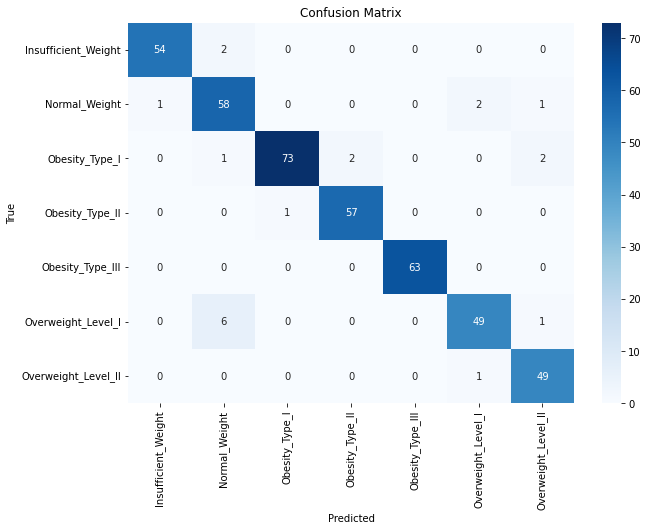

In [15]:
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=le.classes_, yticklabels=le.classes_)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

## Prueba de algoritmo

Tomamos una fila del dataset original.

In [16]:
muestra = obesity_data.iloc[[0]]
muestra

,Gender,Age,Height,Weight,family_history_with_overweight,FAVC,FCVC,NCP,CAEC,SMOKE,CH2O,SCC,FAF,TUE,CALC,MTRANS,NObeyesdad
0,Female,21.0,1.62,64.0,yes,no,2.0,3.0,Sometimes,no,2.0,no,0.0,1.0,no,Public_Transportation,Normal_Weight


Guardamos el valor de salida real de la muestra.

In [17]:
valor_real = muestra["NObeyesdad"][0]
valor_real

'Normal_Weight'

Mantenemos solamente las variables que usará el modelo para predecir.

In [18]:
muestra_X = muestra.drop("NObeyesdad", axis=1)
muestra_X

,Gender,Age,Height,Weight,family_history_with_overweight,FAVC,FCVC,NCP,CAEC,SMOKE,CH2O,SCC,FAF,TUE,CALC,MTRANS
0,Female,21.0,1.62,64.0,yes,no,2.0,3.0,Sometimes,no,2.0,no,0.0,1.0,no,Public_Transportation


Convertimos la muestra a valores categóricos a numéricos para ingresarlos en el modelo.

In [19]:
muestra_X = pd.get_dummies(muestra_X, drop_first=True)
muestra_X

,Age,Height,Weight,FCVC,NCP,CH2O,FAF,TUE
0,21.0,1.62,64.0,2.0,3.0,2.0,0.0,1.0


Observe que el método **get_dummies** no genera el mismo número de columnas al usarlo en el dataset original que al usarlo en la muestra. Para ello se tendrá que añadir las columnas faltantes.

In [20]:
muestra_X = muestra_X.reindex(columns=X.columns, fill_value=0)
muestra_X

,Age,Height,Weight,FCVC,NCP,CH2O,FAF,TUE,Gender_Male,family_history_with_overweight_yes,...,CAEC_no,SMOKE_yes,SCC_yes,CALC_Frequently,CALC_Sometimes,CALC_no,MTRANS_Bike,MTRANS_Motorbike,MTRANS_Public_Transportation,MTRANS_Walking
0,21.0,1.62,64.0,2.0,3.0,2.0,0.0,1.0,0,0,...,0,0,0,0,0,0,0,0,0,0


Escalamos la variables de entrada del mismo modo que se hizo al entrenar.

In [21]:
sample_scaled = scaler.transform(muestra_X)
sample_scaled

array([[-0.53264595, -0.87527637, -0.86610746, -0.7857288 ,  0.40151284,
        -0.01014187, -1.19623756,  0.59027817, -1.01311923, -2.12941922,
        -2.81624163, -0.35719534, -2.24726038, -0.15777752, -0.15378783,
        -0.21412338, -0.18352205, -1.39864833, -0.66260485, -0.04873702,
        -0.07719764, -1.69456768, -0.1729054 ]])

Predecimos con los valores de entrada.

In [22]:
y_pred_num = model.predict(sample_scaled)[0]
y_pred_num

1

Usamos **LabelEncoder** para convertir la salida numérica del modelo a categórica.

In [23]:
y_pred_label = le.inverse_transform([y_pred_num])[0]
y_pred_label

'Normal_Weight'

In [24]:
y_pred_label = le.inverse_transform([y_pred_num])[0]

print(f"Valor real: {valor_real}")
print(f"Predicción: {y_pred_label}")

Valor real: Normal_Weight
Predicción: Normal_Weight
